Examples demonstrating the use of Dask with xarray and pandas
- Use NPL2024a kernel on NCAR Jupyterhub

In [1]:
# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr
import datetime
import pandas as pd
# dask
from dask_jobqueue import PBSCluster
import dask.dataframe as dd
# Libraries to assist with animation and visualisations
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
# other
import os, glob
from pathlib import Path
import time
import datetime

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


# Set up the dask cluster

In [2]:
# connect to dask distributed cluster
n_jobs = 8
# !!!IMPORTANT!!! -> you need to change the account parameter below to an account you belong to
cluster = PBSCluster(account='UPSU0052', 
                     queue='casper', 
                     memory='16GB', 
                     cores=1, 
                     processes=1, 
                     walltime='02:00:00')
cluster.scale(jobs=n_jobs) # scale up by n_jobs
client = cluster.get_client()
print(cluster.job_script()) # show the submitted job script

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33139 instead
  warnings.warn(


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A UPSU0052
#PBS -l select=1:ncpus=1:mem=15GB
#PBS -l walltime=02:00:00

/glade/u/apps/opt/conda/envs/npl-2024a/bin/python -m distributed.cli.dask_worker tcp://128.117.208.103:38829 --nthreads 1 --memory-limit 14.90GiB --name dummy-name --nanny --death-timeout 60



In [3]:
# check that dask-workers are in queue or running (may take a couple minutes)
!qstat -u joko # change to your usename

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
1467015.casper* joko     htc      STDIN       63738   1   1   16gb 02:00 R 00:13


In [4]:
# launch client dashboard to visualize dask diagnostics 
# click on "Launch dashboard in JupyterLab" 
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/joko/proxy/33139/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/joko/proxy/33139/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:38829,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/joko/proxy/33139/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Xarray example
Load a collection of netcdf CM1 output files and do basic calculations

In [5]:
# Load bunch of netcdf files as single dataset
data_folder = '/glade/derecho/scratch/joko/cm1-iceball-nucleation-exp/200' # sample experiment: CM1 simulation with bulk microphysics
save_folder = '/glade/work/joko/nucleation-test/output' # where to save modified dataset (if you want)
Path(save_folder).mkdir(parents=True, exist_ok=True) # make folder if it doesn't exist
bulk_vars = ['qi2', 'qi4'] # subset of variables to look at 
file_path = f'{data_folder}/cm1out_0*.nc' # lets us select all nc files with cm1out- prefix in data_folder
ds = xr.open_mfdataset(file_path, combine='nested', concat_dim=['time'], preprocess=lambda ds: ds[bulk_vars]) # open collection netcdf files

If you look at the data variables in the ds, you will see that the data is chunked automatically by dask under the hood. You can see the visualization of the chunk by pressing the 'Show/Hide data repr' (three little stacked disks symbol) next to a data variable (e.g., qi2). These chunks are sent to the N workers you spawned earlier and they are processed in parallel when you execute some calculations.

In [6]:
ds

<xarray.Dataset>
Dimensions:  (time: 37, zh: 280, yh: 256, xh: 256)
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:05:00 ... 02:55:00 03:00:00
  * xh       (xh) float32 0.025 0.075 0.125 0.175 ... 12.63 12.68 12.73 12.78
  * yh       (yh) float32 0.025 0.075 0.125 0.175 ... 12.63 12.68 12.73 12.78
  * zh       (zh) float32 0.025 0.075 0.125 0.175 ... 13.83 13.88 13.93 13.98
Data variables:
    qi2      (time, zh, yh, xh) float32 dask.array<chunksize=(1, 1, 256, 256), meta=np.ndarray>
    qi4      (time, zh, yh, xh) float32 dask.array<chunksize=(1, 1, 256, 256), meta=np.ndarray>
Attributes: (12/71)
    CM1 version:    cm1r21.0
    Conventions:    CF-1.7
    missing_value:  -999999.9
    x_units:        km
    x_label:        x
    y_units:        km
    ...             ...
    cgt1:           1.875
    cgt2:           -1.25
    cgt3:           0.375
    dgt1:           2.0
    dgt2:           -3.0
    dgt3:           1.0

In [7]:
# define some calculations (e.g., calculate the mean, sum, etc.)
ds_mean = ds.mean(dim=['xh', 'yh']) # calculate mean vertical profile
ds_mean = ds_mean.assign(qi = ds_mean['qi2'] + ds_mean['qi4']) # sum/assign total mass mixing ratio

In [8]:
ds_mean

<xarray.Dataset>
Dimensions:  (time: 37, zh: 280)
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:05:00 ... 02:55:00 03:00:00
  * zh       (zh) float32 0.025 0.075 0.125 0.175 ... 13.83 13.88 13.93 13.98
Data variables:
    qi2      (time, zh) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    qi4      (time, zh) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    qi       (time, zh) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

At this point, the calculations haven't actually been executed. You will need to explicitly call compute() for dask to execute the computations across the distibuted cluster.

In [9]:
# execute the calculations
ds_mean = ds_mean.compute()

In [10]:
# look at the new dataset (now you will see numeric values in the dataset)
ds_mean

<xarray.Dataset>
Dimensions:  (time: 37, zh: 280)
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 00:05:00 ... 02:55:00 03:00:00
  * zh       (zh) float32 0.025 0.075 0.125 0.175 ... 13.83 13.88 13.93 13.98
Data variables:
    qi2      (time, zh) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    qi4      (time, zh) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    qi       (time, zh) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

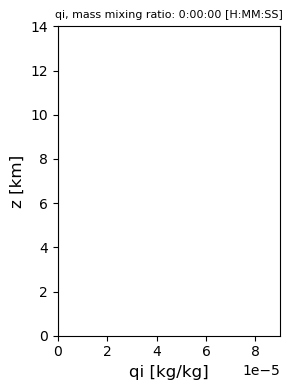

In [13]:
# Example viz: create animation of vertical profile changing over the simulation time period

# initialize plot
fig, ax = plt.subplots(figsize=(3, 4))
line, = ax.plot(ds_mean.qi[0, :], ds_mean.zh)
x_max, y_max = 9e-5, 14
ax.set_xlabel('qi [kg/kg]', fontsize=12)
ax.set_ylabel('z [km]', fontsize=12)
ax.set_ylim(0, y_max)
ax.set_xlim(0, x_max)
fig.set_tight_layout(True)
time_array = ds_mean.time.values

# create function that will be called by animation object
frames = 37
def animate(i):
    line.set_xdata(ds_mean.qi[i, :])
    timestamp = time_array[i]
    timestamp_seconds = timestamp / np.timedelta64(1, 's')
    timestamp_str = str(datetime.timedelta(seconds = timestamp_seconds))
    title = f'qi, mass mixing ratio: {timestamp_str} [H:MM:SS]'
    ax.set_title(title, fontsize=8)
    return line,
    
# create animation object & save
ani = animation.FuncAnimation(fig, animate, frames, interval=150)

# # if you want to save the figure
# save_folder = '/glade/u/home/joko/cm1/analysis/bulk_sdm_comparison/output/figures' # folder to save
# save_filename = 'bulk_old_irho6_qi_z_profile_ts.mp4' # name of file to save
# save_path = os.path.join(save_folder, save_filename)
# ani.save(save_path)

# display w/ Javascript
HTML(ani.to_jshtml())

# Pandas example
Load a collection of CM1 SDM trajectory files and do basic calculations

In [41]:
# Read 10 files from single timestep (05400) 
data_folder = '/glade/derecho/scratch/klamb/superdroplets/outsdm_iceball_nowind_rhod_dist_min200_time_var_sgs_1024_poly_trj/SDM_trajs'
file_path = f'{data_folder}/SD_output_ASCII_05400*' # files with 05400 timestamp prefix
list_paths = glob.glob(file_path)
list_paths.sort()
n_files = 10 # just use first 10 files
colnames =['x[m]', 'y[m]', 'z[m]', 'vz[m]','radius(droplet)[m]',
           'mass_of_aerosol_in_droplet/ice(1:01)[g]', 'radius_eq(ice)[m]',
           'radius_pol(ice)[m]', 'density(droplet/ice)[kg/m3]', 'rhod [kg/m3]',
           'multiplicity[-]','status[-]','index','rime_mass[kg]',
           'num_of_monomers[-]','rk_deact']
# df = dd.read_csv(list_paths[:n_files])
df = dd.read_csv(list_paths[:n_files], sep = '\s+', skiprows=1, 
                 header=None, delim_whitespace=False, 
                 names=colnames).set_index('rk_deact')
df

,x[m],y[m],z[m],vz[m],radius(droplet)[m],mass_of_aerosol_in_droplet/ice(1:01)[g],radius_eq(ice)[m],radius_pol(ice)[m],density(droplet/ice)[kg/m3],rhod [kg/m3],multiplicity[-],status[-],index,rime_mass[kg],num_of_monomers[-]
npartitions=10,,,,,,,,,,,,,,,
345,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,string,int64,float64,int64
1806846,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16891124,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015106738,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Dask has paritioned the dataset into 10 parts - one for each file.

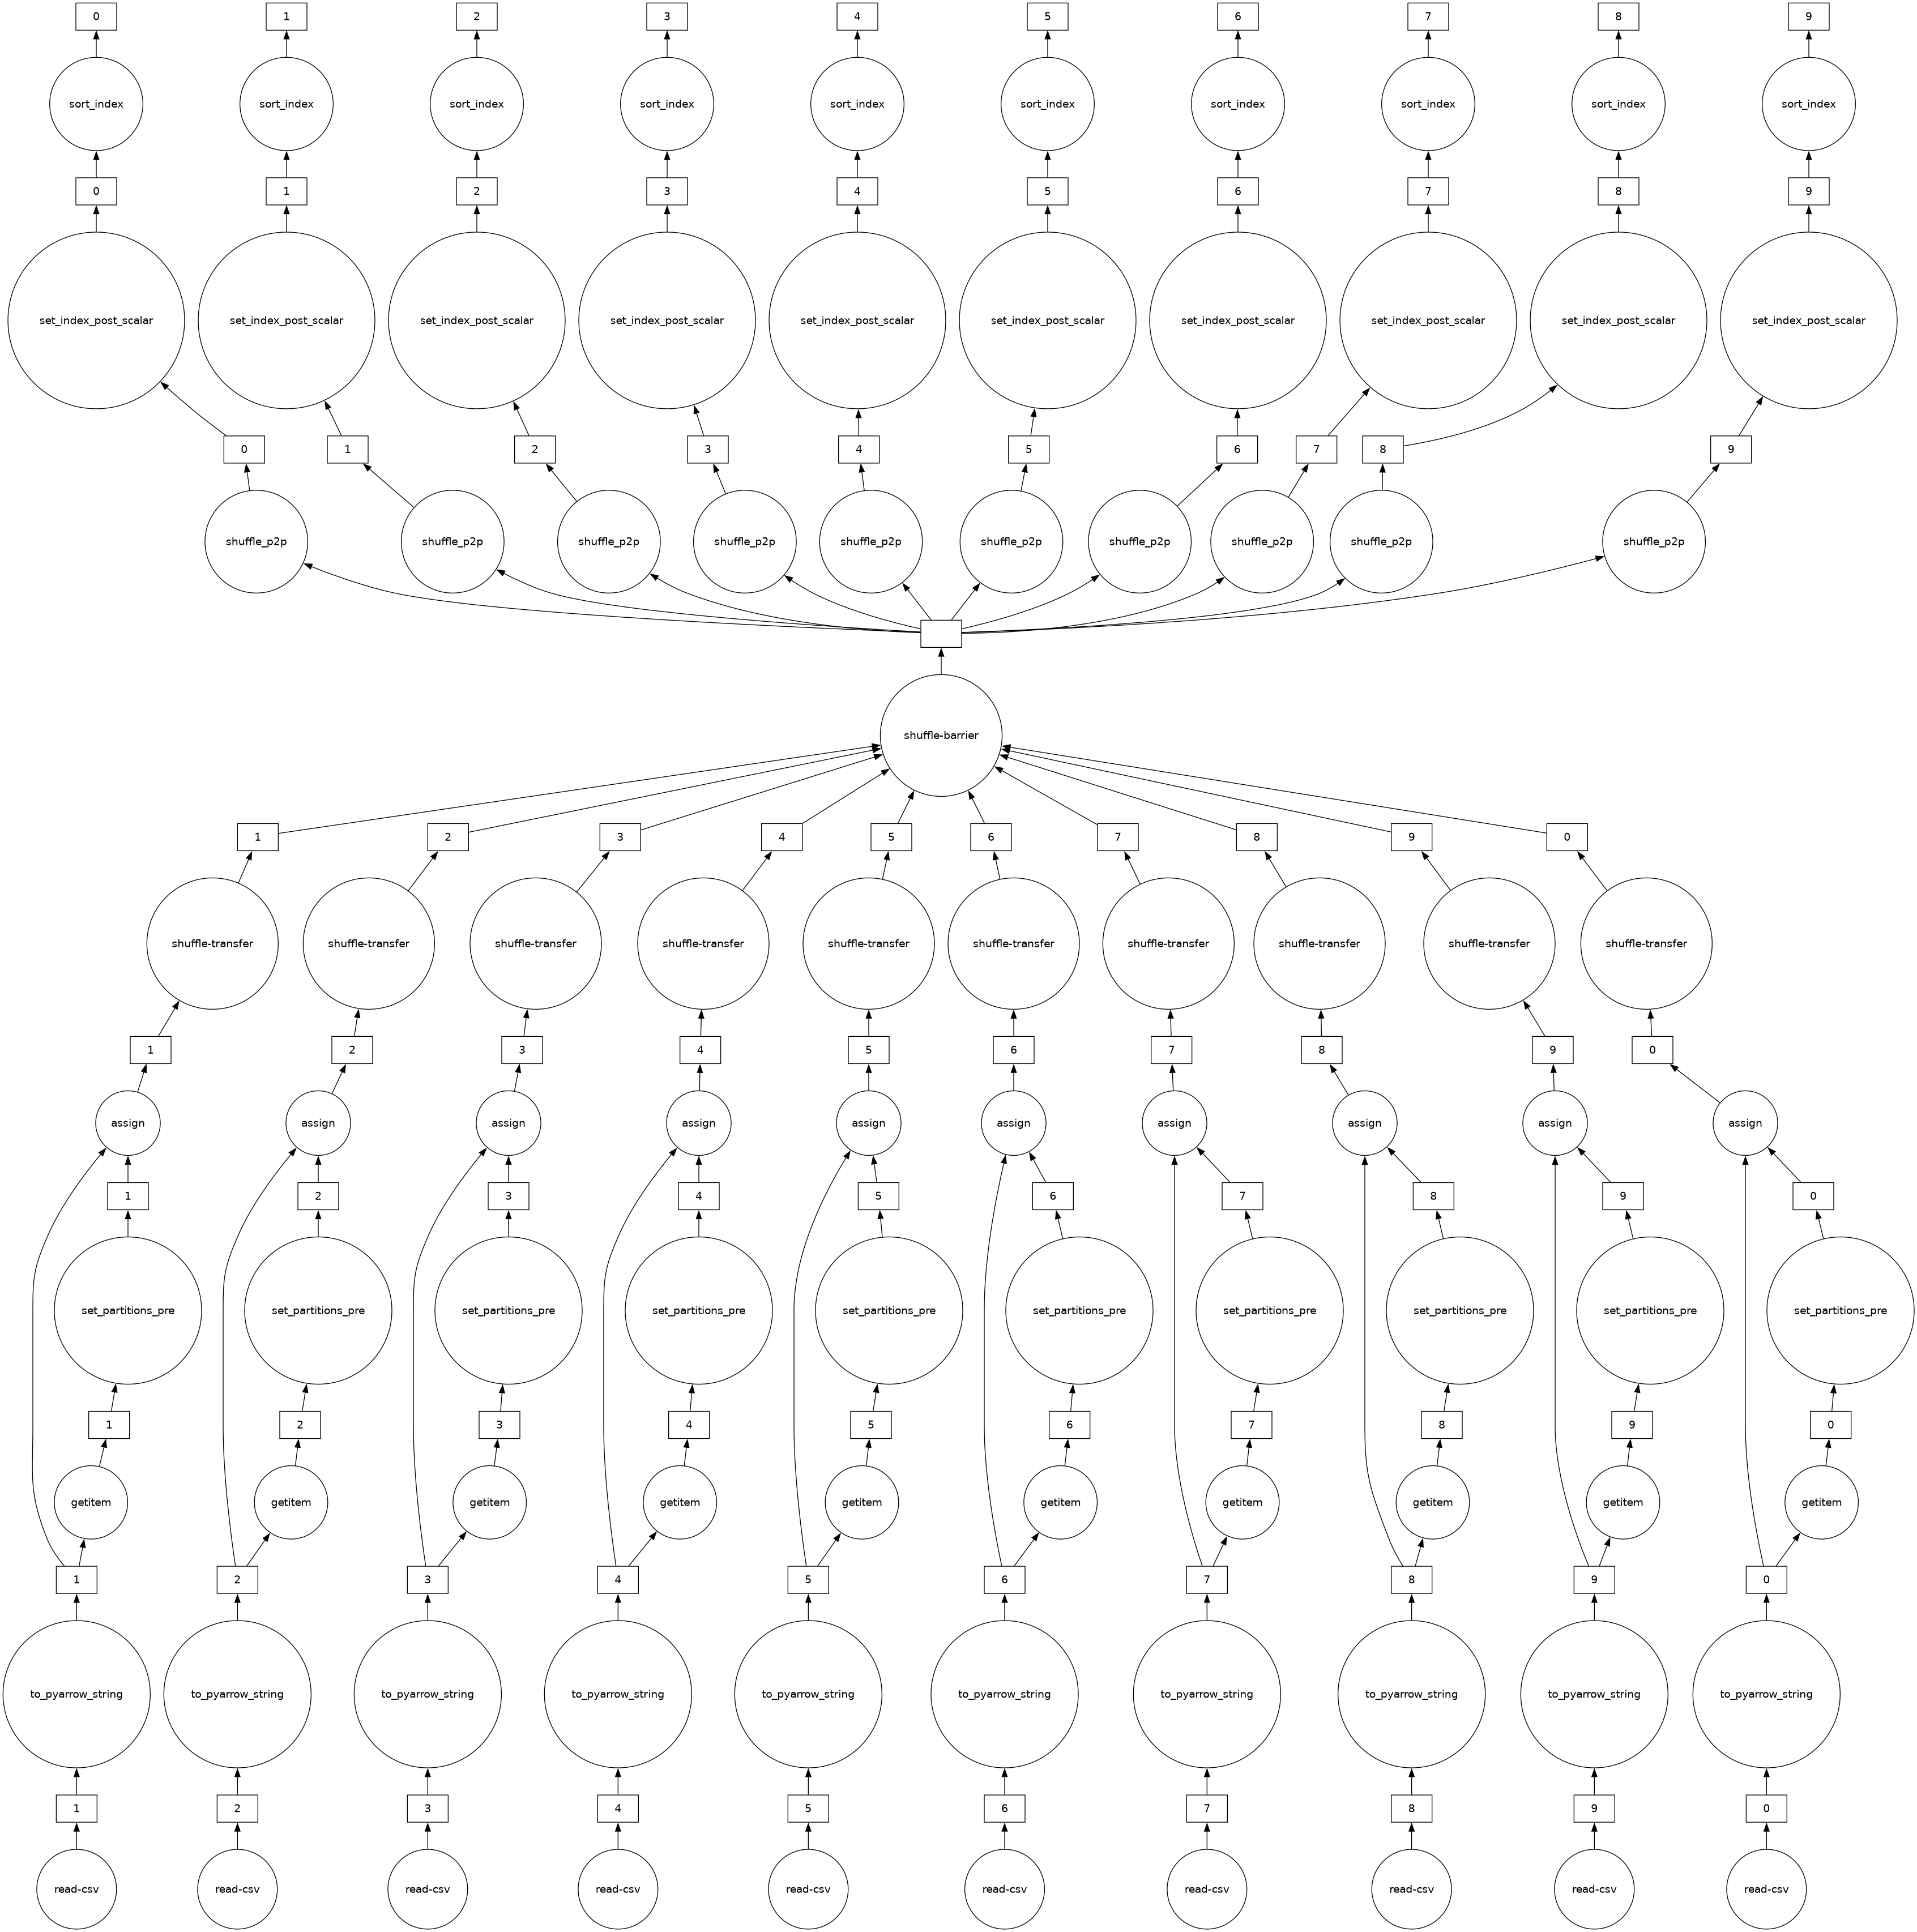

In [42]:
df.visualize()

first basic computation: len() will trigger a load + computation

In [43]:
# load and count number of rows 
len(df)

29184

Do a more non-trivial computation

In [44]:
df.columns

Index(['x[m]', 'y[m]', 'z[m]', 'vz[m]', 'radius(droplet)[m]',
       'mass_of_aerosol_in_droplet/ice(1:01)[g]', 'radius_eq(ice)[m]',
       'radius_pol(ice)[m]', 'density(droplet/ice)[kg/m3]', 'rhod [kg/m3]',
       'multiplicity[-]', 'status[-]', 'index', 'rime_mass[kg]',
       'num_of_monomers[-]'],
      dtype='object')

In [46]:
# find max deposition density in df
rhod_max = df['rhod [kg/m3]'].mean()
rhod_max.compute()

326.9066903097588

In [49]:
# calculate mass [kg] of each particle 
vol = (4/3) * np.pi * (df['radius_eq(ice)[m]'])**3
mass = vol * df['density(droplet/ice)[kg/m3]']
mass = mass.compute()
mass[:10] # print first values

rk_deact
345     4.138503e-12
514     3.840283e-18
872     2.391284e-12
1107    3.538875e-11
1677    3.997967e-12
1706    1.457659e-11
2948    1.885877e-09
3789    2.494490e-11
4456    6.603189e-12
5120    1.351115e-10
dtype: float64